# Project: Predicting Stock Price & Return  
## 4.Deep Learning
Data source include: Alphavantage free API, Bank of Canada, Google Trends

Ver. 1.0  
Remove unecessary content  
Ver. 0.2  
Build a LSTM model with return level targets  
Ver. 0.1  
First try of deep learning model

#### 0. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras import optimizers

Using TensorFlow backend.


In [3]:
#let the notebook display full length of the data columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#### 1. Prepare the data

In [4]:
df = pd.read_csv("data_feature_created.csv", parse_dates=['date'], index_col = 'date')

In [5]:
#feature_names = ['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma14', 'sp500_rsi14', 'sp500_ma30', 'sp500_rsi30', 'sp500_ma50', 'sp500_rsi50', 'sp500_ma200', 'sp500_rsi200', 'sp500_5d_pct', 'sp500_price', 'sp500_volume_1d_pct_SMA', 'BCPI', 'CPI', 'bank_interest', 'CEER', 'trend_grocery_store', 'trend_loblaws', 'trend_stock']

In [6]:
feature_names=['trend_grocery_store', 'trend_loblaws', 'gwl_price', 'CPI',
       'atd_price', 'BCPI', 'loblaw_price', 'metro_price', 'empa_price',
       'tsx_price', 'sp500_price', 'trend_stock', 'CEER']

In [7]:
features = df[feature_names]
targets = df[['loblaws_20d_return_level']].values.ravel() 

In [8]:
from sklearn.preprocessing import scale
scaled_features = scale(features)

In [9]:
scaled_features.shape

(4084, 13)

In [10]:
batch_size = 64
timesteps = 20

In [11]:
scaled_lstm_features = []
for column in range(scaled_features.shape[1]):
    time_series = []
    for i in range(len(scaled_features) - timesteps):
        time_series.append(scaled_features[i:i + timesteps, column])
    scaled_lstm_features.append(time_series)
scaled_lstm_features = np.dstack(scaled_lstm_features)
print(type(scaled_lstm_features))
print(scaled_lstm_features.shape)

<class 'numpy.ndarray'>
(4064, 20, 13)


In [12]:
lstm_targets = targets[timesteps:]

In [13]:
lstm_targets.shape

(4064,)

In [14]:
scaled_lstm_features.shape

(4064, 20, 13)

In [15]:
train_size = int(0.75 * scaled_lstm_features.shape[0])
train_start = train_size % batch_size

scaled_train_features = scaled_lstm_features[train_start:train_size]
train_targets = lstm_targets[train_start:train_size]
scaled_test_features = scaled_lstm_features[train_size:]
test_targets = lstm_targets[train_size:]

print(scaled_train_features.shape, train_targets.shape)
print(scaled_test_features.shape, test_targets.shape)


(3008, 20, 13) (3008,)
(1016, 20, 13) (1016,)


#### 2. Build the model

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


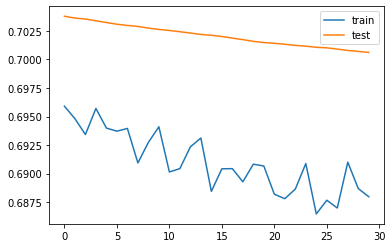

[[ 81 405]
 [120 410]]
0.48326771653543305


In [17]:
n_cells = 20
dropout = 0.25
lr = 0.001
momentum = 0.0
epochs = 30

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

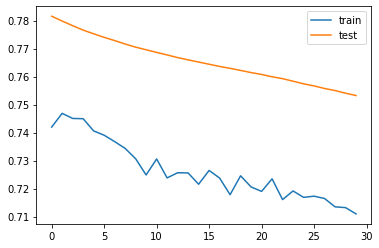

[[261 225]
 [322 208]]
0.46161417322834647


In [18]:
n_cells = 20
dropout = 0.5
lr = 0.001
momentum = 0.0
epochs = 30

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

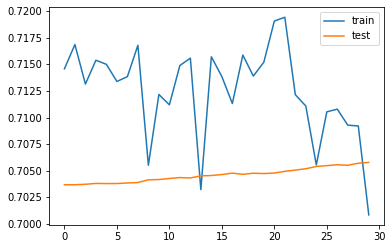

[[  3 483]
 [  1 529]]
0.5236220472440944


In [19]:
n_cells = 20
dropout = 0.75
lr = 0.001
momentum = 0.0
epochs = 30

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

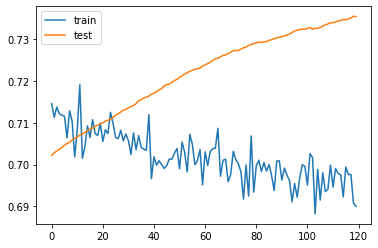

[[  0 486]
 [  0 530]]
0.5216535433070866


In [20]:
n_cells = 20
dropout = 0.75
lr = 0.001
momentum = 0.0
epochs = 120

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

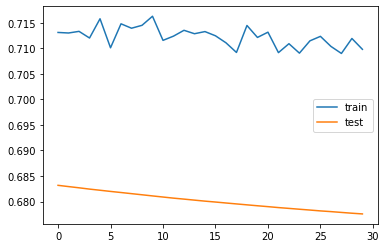

[[417  69]
 [384 146]]
0.5541338582677166


In [21]:
n_cells = 50
dropout = 0.5
lr = 0.0001
momentum = 0.0
epochs = 30

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

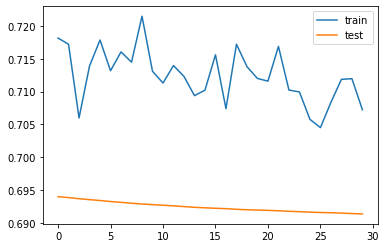

[[325 161]
 [292 238]]
0.5541338582677166


In [21]:
n_cells = 50
dropout = 0.5
lr = 0.0003
momentum = 0.0
epochs = 30

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

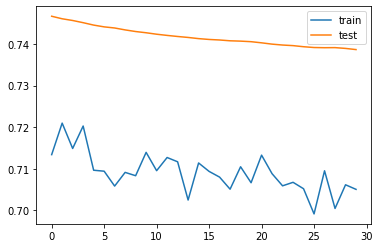

[[169 317]
 [268 262]]
0.4242125984251969


In [22]:
n_cells = 50
dropout = 0.5
lr = 0.0006
momentum = 0.0
epochs = 30

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

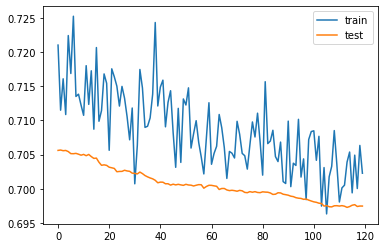

[[207 279]
 [194 336]]
0.5344488188976378


In [23]:
n_cells = 20
dropout = 0.5
lr = 0.0005
momentum = 0.0
epochs = 120

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

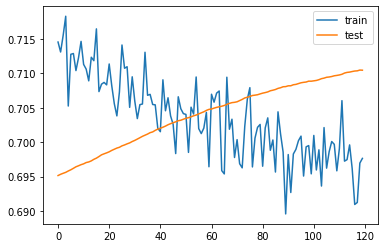

[[ 37 449]
 [ 69 461]]
0.49015748031496065


In [24]:
n_cells = 50
dropout = 0.5
lr = 0.0003
momentum = 0.0
epochs = 120

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))

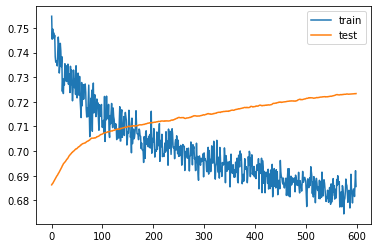

[[ 14 472]
 [ 20 510]]
0.515748031496063


In [25]:
n_cells = 20
dropout = 0.5
lr = 0.0005
momentum = 0.0
epochs = 600

model = Sequential()
model.add(LSTM(n_cells, input_shape=(scaled_train_features.shape[1], scaled_train_features.shape[2]),dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr = lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd)

history = model.fit(scaled_train_features, train_targets, epochs=epochs, batch_size=batch_size, 
                    validation_data=(scaled_test_features, test_targets), verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_pred = model.predict(scaled_test_features)

print(confusion_matrix(test_targets, test_pred > 0.5))
print(accuracy_score(test_targets, test_pred > 0.5))